z_value 1.959963984540054
-1.9599639845400545


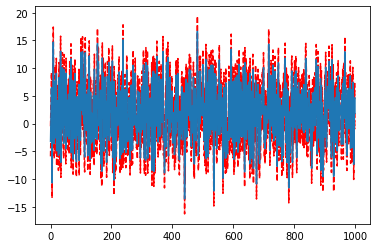

In [129]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1, 1)
# генеральная совокупность
population=norm.rvs(loc=2,scale=5, size=1000)
sample_size=100
# выбор размер выборки
sample=np.random.choice(a=population, size=sample_size)

sample_mean=sample.mean()
st_dev= population.std()

z_value = norm.ppf(q=0.975)
print('z_value', z_value)
stats_norm = norm.ppf(q=0.025)
print(stats_norm)

interval = z_value*(st_dev/np.sqrt(sample_size))
doverit_interv = sample_mean+interval


plt.plot(population+doverit_interv,'r--')
plt.plot(population-doverit_interv,'r--')
plt.plot(population)
#print(population)

In [130]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

In [172]:
#data = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'])
#data = pd.read_csv('ik03_z.csv', index_col=['Time'], parse_dates=['Time'])
#data1 = pd.read_csv('iat1.csv', index_col=['Time'], parse_dates=['Time'])
dtest = pd.read_csv('iat3.txt', index_col=['Time'], parse_dates=['Time'])
ip02 = pd.read_csv('ip02_X.txt', index_col=['Time'], parse_dates=['Time'])
#data = pd.read_csv('iat3_clear.txt', index_col=['Time'], parse_dates=['Time'])
#data = pd.read_csv('iat1cut2.txt', index_col=['Time'], parse_dates=['Time'])
#data = pd.read_csv('iat3x.txt', index_col=['Time'], parse_dates=['Time'])
data = pd.read_csv('iat1.csv', index_col=['Time'], parse_dates=['Time'])
data.columns = ["y"]
#ads = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])

In [151]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [152]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
# Добавляет лаги сдвигает вниз от и до 
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))
    print(test_index)

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        #print(data)
    data.index = pd.to_datetime(data.index)
    #data.index = data.index.to_datetime()
#    data["hour"] = data.index.hour
#    data["weekday"] = data.index.weekday
#    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    #                               сред                          
#    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    #print(list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday)))
#    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # выкидываем закодированные средними признаки 
#    data.drop(["hour", "weekday","is_weekend"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [153]:
def testPrepareData(data, lag_start=5, lag_end=20):
# Добавляет лаги сдвигает вниз от и до 
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    test_index = int(len(data)*(1))
    # добавляем лаги исходного ряда в качестве признаков
    print
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)

    data.index = pd.to_datetime(data.index)

    data = data.dropna()
    data = data.reset_index(drop=True)

    X_test = data.loc[:test_index].drop(["y"], axis=1)
    y_test = data.loc[:test_index]["y"]

    return X_test, y_test

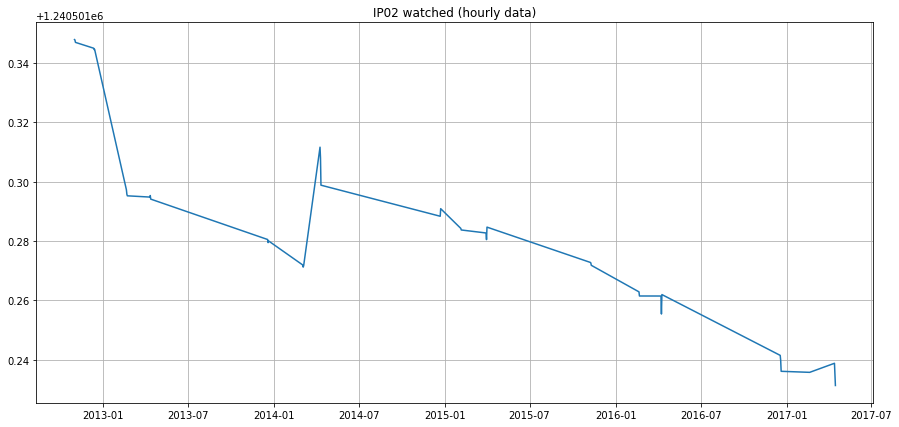

In [154]:
plt.figure(figsize=(15, 7))
#plt.plot(ads.Ads)
plt.plot(ip02.Z)
plt.title('IP02 watched (hourly data)')
plt.grid(True)
plt.show()


In [155]:
# инициализация тестовой выборки
#X_x, Y_y = testPrepareData(ip02, 12, 24)
#X_x, Y_y = testPrepareData(data, 12, 24)

    

In [164]:
import xgboost as xgb

def XGB_forecast(data, test_x, test_y, lag_start=1, lag_end=2, test_size=0.15, ):
    
    scale=1.96
    # для тестой выборки после обучения модели
    #print(test_x)
    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(data, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    dXtest = xgb.DMatrix(test_x)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)
    
    #print('chislo  ',cv['test-rmse-mean'].argmin())
    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])
    #cv.plot(y=['test-rmse-mean', 'train-rmse-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
#    prediction_train = bst.predict(dtrain)
#    plt.figure(figsize=(25, 15))
#    plt.plot(prediction_train)
#    plt.plot(y_train)
#    plt.axis('tight')
#    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    #prediction2_test = bst.predict(dXtest)
   
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]
    Anomalies[y_test>upper] = y_test[y_test>upper]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} ".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()
    
   
    #return(prediction2_test)

3186
[14:14:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:45] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:14:45] 

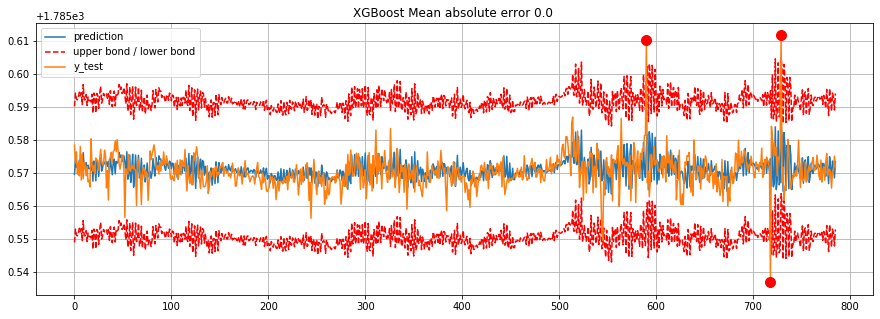

In [174]:

#predict = XGB_forecast(ip02,  test_x=X_x, test_y=Y_y, test_size=0.6, lag_start=1, lag_end=1)
XGB_forecast(dtest,  test_x=X_x, test_y=Y_y, test_size=0.2, lag_start=1, lag_end=12)

mae 148938.62618184343
std 0.03988404
size 3960
deviation 0.015072089322075908


<Figure size 432x288 with 0 Axes>

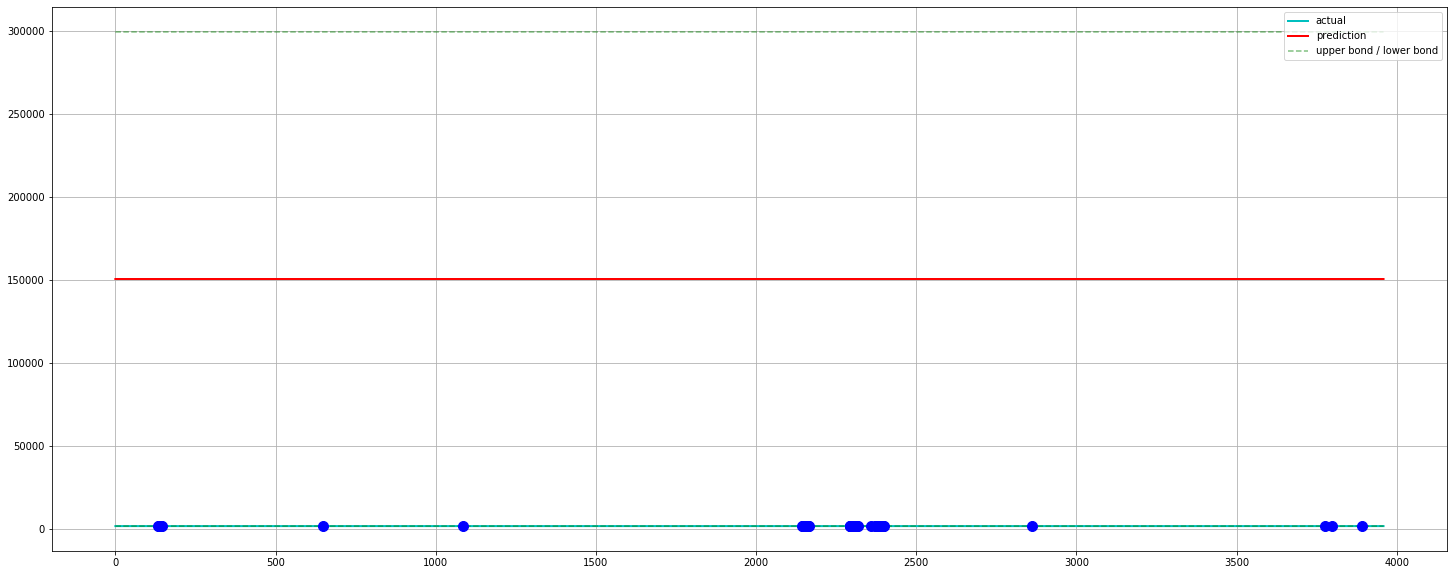

In [89]:
plt.clf()
plt.figure(figsize=(25, 10))

mae = mean_absolute_error(Y_y, predict)
print('mae',mae)
mean_predic = predict.mean()
#print('mean', mean_x)
std_predic = predict.std()
print('std',std_predic)
size_predict = len(predict)
print('size',size_predict)
#interval = 1.96*(std_predic/np.sqrt(size_predict))
#print('coeff dover ',interval)
                             #     чет не очень
#doverit_interv = mean_predic + interval
#doverit_interv = predict - doverit_interv
#doverit_interv2 = predict + interval
#print('doveritelni_inter - ',doverit_interv)
#print('doveritelni_inter + ',doverit_interv2)
                                            # доверительный mae
deviation = np.std(Y_y - predict)
print('deviation', deviation)
upper = predict + (mae + 1.96 * deviation)#
lower = predict - (mae + 1.96 * deviation)#
#upper = predict + (mae + 1.96 * std_predic)#
#lower = predict - (mae + 1.96 * std_predic)#

#upper =  predict - doverit_interv
#lower = (doverit_interv2)
#print(predict)
#print('low',lower)
#plt.plot(a)
plt.plot(Y_y.values,"c", label="actual", linewidth=2.0)#
#plt.plot(predict, "r", label="prediction")#
plt.plot(predict, "r", label="prediction", linewidth=2.0)#

plt.plot(lower, "g--", label="upper bond / lower bond", alpha=0.5)#
plt.plot(upper, "g--", alpha=0.5)#

Anomalies = np.array([np.NaN]*len(Y_y)) # пустой массив
Anomalies[Y_y>upper] = Y_y[Y_y>upper]
Anomalies[Y_y<lower] = Y_y[Y_y<lower]

plt.plot(Anomalies, "bo", markersize=10)
#print(len(predict))
#anomalies[data>upper]
#anomalies[series>upper] = series[series>upper]
#plt.plot(anomalies, "ro", markersize=10)
#plt.plot(X_x)
#plt.plot(doverit_interv2)
plt.grid(True)#
plt.legend()#
#dtest.head()     


In [12]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
#from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from matplotlib.colors import ListedColormap
from sklearn import  datasets, metrics, linear_model
from sklearn import datasets, metrics, linear_model



%matplotlib inline